### **Importación de Módulos y Librerías Necesarias**

In [115]:
import os
import cv2
import shutil
import torch
import optuna
import matplotlib
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pathlib import Path
from PIL import ImageEnhance
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

### **Optimización de Hiperparámetros con Optuna**

Este código implementa un proceso de optimización de hiperparámetros utilizando **Optuna**, un marco para optimizar parámetros de modelos de machine learning. El objetivo principal es encontrar los mejores valores de hiperparámetros para el modelo de red neuronal convolutiva (CNN) diseñado para clasificar imágenes de piezas de ajedrez.

In [57]:
def objective(trial):
    # Selección de hiperparámetros
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Ruta de datos
    data_path = os.path.join('datos_ajedrez', 'Chessman-image-dataset', 'Chess')

    # Transformaciones para los datos
    transform_train = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Carga de datos y partición en conjuntos de entrenamiento y prueba
    full_data = datasets.ImageFolder(root=data_path, transform=transform_train)
    train_size = int(0.8 * len(full_data))
    test_size = len(full_data) - train_size
    train_data, test_data = random_split(full_data, [train_size, test_size])
    test_data.dataset.transform = transform_test

    # Creación de dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Definición del modelo CNN
    class ConvNet(nn.Module):
        def __init__(self, num_classes, dropout_rate):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(128 * 8 * 8, 256)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Configuración del dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Inicialización del modelo, función de pérdida y optimizador
    num_classes = len(full_data.classes)
    model = ConvNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Entrenamiento
    epochs = 5
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

# Optimización de hiperparámetros
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-07 22:10:30,752] A new study created in memory with name: no-name-bf81d57d-a776-43a5-b1d2-6b696b506a71
[I 2024-12-07 22:10:47,357] Trial 0 finished with value: 18.01801801801802 and parameters: {'batch_size': 32, 'lr': 0.05454120976279904, 'dropout_rate': 0.23462035808143616}. Best is trial 0 with value: 18.01801801801802.
[I 2024-12-07 22:11:03,904] Trial 1 finished with value: 23.423423423423422 and parameters: {'batch_size': 64, 'lr': 0.049857167320813904, 'dropout_rate': 0.3244757289304048}. Best is trial 1 with value: 23.423423423423422.
[I 2024-12-07 22:11:20,975] Trial 2 finished with value: 17.117117117117118 and parameters: {'batch_size': 128, 'lr': 9.915481087423277e-05, 'dropout_rate': 0.41225649090520633}. Best is trial 1 with value: 23.423423423423422.
[I 2024-12-07 22:11:37,947] Trial 3 finished with value: 18.91891891891892 and parameters: {'batch_size': 64, 'lr': 0.06127233379111301, 'dropout_rate': 0.3286612232487075}. Best is trial 1 with value: 23.42342342

Best hyperparameters: {'batch_size': 16, 'lr': 0.0013927852978010606, 'dropout_rate': 0.1058834626131078}


El proceso de optimización con **Optuna** identificó los mejores hiperparámetros para el modelo de red neuronal convolutiva (CNN), obteniendo un tamaño de lote (`batch_size`) de 16, una tasa de aprendizaje (`lr`) de aproximadamente 0.0014, y una tasa de dropout (`dropout_rate`) del 10.6%.  Estos valores representan una configuración óptima para maximizar la precisión y proporcionar un modelo robusto y eficiente.

### **Clasificador Básico**

#### **1. Transformaciones y Carga de Datos**

In [58]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionamos las imágenes a 64x64 píxeles
    transforms.ToTensor(),  # Convertimos las imágenes en tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizamos los datos en el rango [-1, 1]
])

# Ruta de las imágenes
data_path = os.path.join('datos_ajedrez', 'Chessman-image-dataset', 'Chess')

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

En esta sección, se cargan y transforman las imágenes para prepararlas como entrada para el modelo de clasificación. Las imágenes se redimensionan a 64x64 píxeles para asegurar uniformidad, se convierten a tensores y se normalizan al rango [-1, 1] para facilitar el entrenamiento del modelo. Posteriormente, el conjunto de datos completo se divide en dos partes: un 80% para el entrenamiento del modelo y un 20% para la evaluación en el conjunto de prueba, asegurando que ambas divisiones mantengan la misma estructura y transformaciones.

#### **2. Definición de Modelos CNN**
##### **Modelo Básico: ConvNet**

In [59]:
class ConvNet(nn.Module):
    def __init__(self, classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### **Modelo Avanzado: ConvNet2**

In [60]:
class ConvNet2(nn.Module):
    def __init__(self, classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### **Modelo Complejo: ConvNet3**

In [61]:
class ConvNet3(nn.Module):
    def __init__(self, classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        # print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Se definen tres modelos con arquitecturas de diferente complejidad. Cada modelo utiliza varias capas convolutivas y de pooling para extraer características de las imágenes, seguido de capas totalmente conectadas para la clasificación final.

#### **3. Parada Temprana**

In [62]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_val_loss = float('inf')

    def __call__(self, validation_loss):
        if (self.best_val_loss - validation_loss) > self.min_delta:
            self.counter = 0  
            self.best_val_loss = validation_loss
        else:
            self.counter += 1 
        
        if self.counter >= self.tolerance:
            self.early_stop = True
            print("Parada temprana activada. No hay mejora en la pérdida de validación.")

Se implementa un mecanismo de parada temprana para detener el entrenamiento si no se mejora la pérdida de validación después de un número de épocas consecutivas, evitando sobreajuste y ahorro de tiempo.

#### **4. Entrenamiento y Evaluación**

##### **Función para Entrenar el Modelo por Época**

In [63]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

Esta función realiza una época de entrenamiento sobre el conjunto de datos de entrada. Durante esta etapa, procesa los datos en pequeños lotes, calculando primero las predicciones del modelo para cada lote. Luego, evalúa el error de las predicciones comparándolas con las etiquetas reales utilizando una función de pérdida. A continuación, ajusta los pesos del modelo mediante el proceso de retropropagación, que calcula los gradientes, y el optimizador, que actualiza los pesos para minimizar la pérdida. Al finalizar la época, la función calcula y devuelve la pérdida promedio acumulada y la precisión del modelo, lo que proporciona una evaluación del rendimiento del modelo durante esa fase de entrenamiento.

##### **Función para Evaluar el Modelo**

In [64]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds

Esta función evalúa el rendimiento del modelo utilizando el conjunto de prueba. Para cada lote de datos en este conjunto, calcula las predicciones del modelo y evalúa el error comparándolas con las etiquetas reales mediante una función de pérdida. Además, registra las etiquetas reales y las predicciones generadas, lo que permite realizar análisis posteriores, como la creación de una matriz de confusión. Al finalizar, la función devuelve la pérdida promedio acumulada en el conjunto de prueba, la precisión del modelo y una lista con todas las etiquetas reales y las predicciones, proporcionando así una visión completa del desempeño del modelo en datos no vistos.

##### **Función para Graficar Métricas**

In [69]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):
 
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Matriz de confusión
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for true_label, pred_label in zip(all_labels, all_preds):
        confusion_matrix[true_label, pred_label] += 1

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

##### **Función para Entrenar el Modelo**

In [70]:

def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs, start_early_stop=1):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop and epoch>start_early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

### **Clasificador Básico - Sin Parada Temprana**

Epoch 1, Training Loss: 1.8135207508291518, Training Accuracy: 17.687074829931973%
Epoch 1, Test Loss: 1.7797867911202567, Test Accuracy: 16.216216216216218%
Epoch 2, Training Loss: 1.7372182522501265, Training Accuracy: 27.43764172335601%
Epoch 2, Test Loss: 1.7818022966384888, Test Accuracy: 18.91891891891892%
Epoch 3, Training Loss: 1.6367901308195931, Training Accuracy: 30.385487528344672%
Epoch 3, Test Loss: 1.8126832587378365, Test Accuracy: 25.225225225225227%
Epoch 4, Training Loss: 1.4438401673521315, Training Accuracy: 46.48526077097506%
Epoch 4, Test Loss: 1.8272342341286796, Test Accuracy: 22.52252252252252%
Epoch 5, Training Loss: 1.2566076900277818, Training Accuracy: 55.10204081632653%
Epoch 5, Test Loss: 1.8179339170455933, Test Accuracy: 26.126126126126128%
Epoch 6, Training Loss: 1.0197457543441228, Training Accuracy: 63.265306122448976%
Epoch 6, Test Loss: 2.0559432336262295, Test Accuracy: 36.03603603603604%
Epoch 7, Training Loss: 0.859683462551662, Training Accura

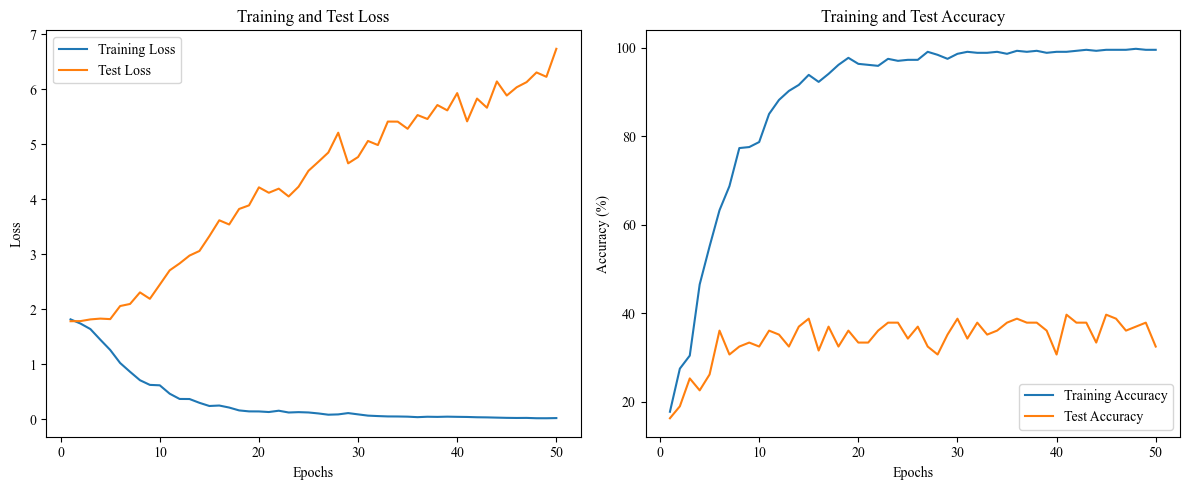

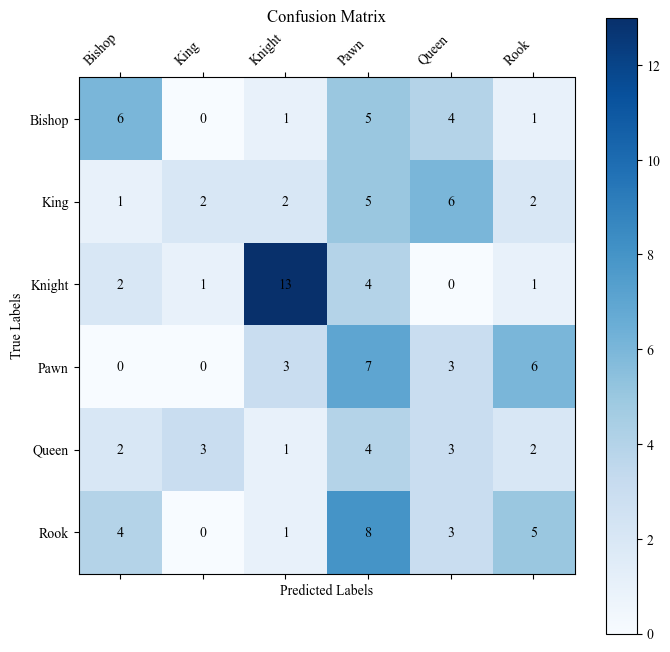

In [71]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, [], epochs=50)

### **Clasificador Básico - Con Parada Temprana**

Epoch 1, Training Loss: 1.7909878577504839, Training Accuracy: 20.861678004535147%
Epoch 1, Test Loss: 1.7668684550694056, Test Accuracy: 16.216216216216218%
Epoch 2, Training Loss: 1.7243406176567078, Training Accuracy: 25.85034013605442%
Epoch 2, Test Loss: 1.7550465549741472, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.610709207398551, Training Accuracy: 34.69387755102041%
Epoch 3, Test Loss: 1.7869807822363717, Test Accuracy: 18.01801801801802%
Epoch 4, Training Loss: 1.4438460511820657, Training Accuracy: 43.99092970521542%
Epoch 4, Test Loss: 1.7506354366030012, Test Accuracy: 29.72972972972973%
Epoch 5, Training Loss: 1.2854815210614885, Training Accuracy: 52.15419501133787%
Epoch 5, Test Loss: 1.8209505762372697, Test Accuracy: 34.234234234234236%
Epoch 6, Training Loss: 1.14706737441676, Training Accuracy: 58.049886621315196%
Epoch 6, Test Loss: 1.8214547804423742, Test Accuracy: 30.63063063063063%
Epoch 7, Training Loss: 0.9892635707344327, Training Accuracy: 

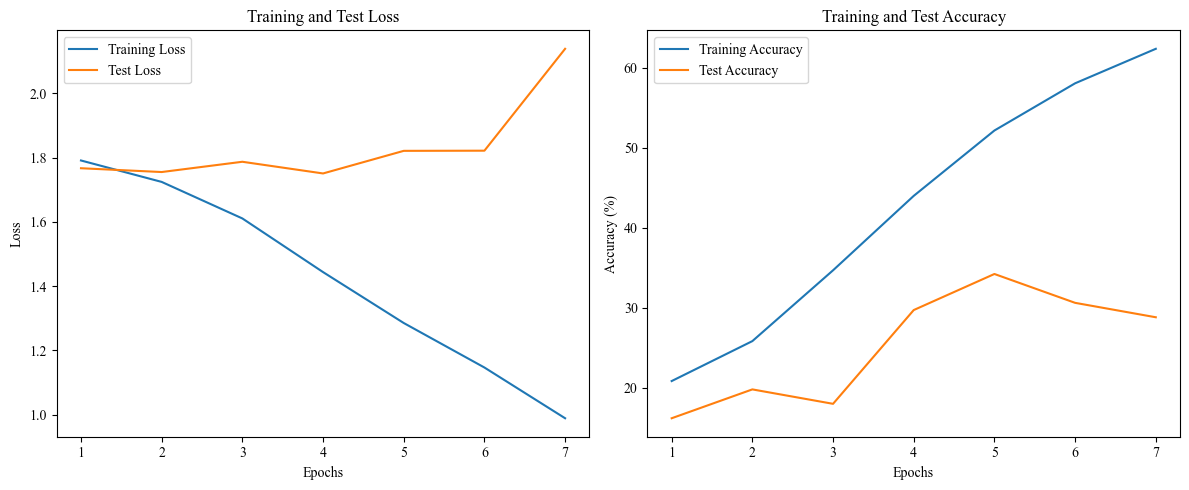

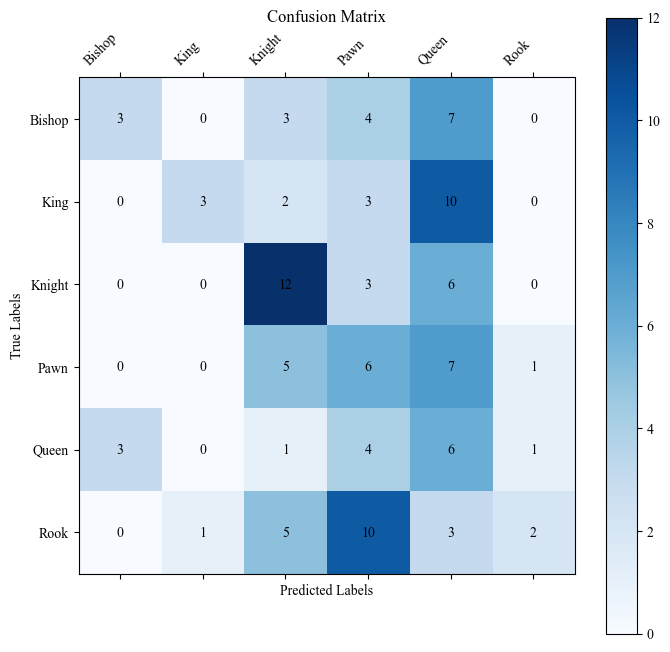

In [72]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

### **Clasificador Básico - Con 4 capas convolutivas**

Epoch 1, Training Loss: 1.7936379952090127, Training Accuracy: 16.3265306122449%
Epoch 1, Test Loss: 1.785197275025504, Test Accuracy: 18.91891891891892%
Epoch 2, Training Loss: 1.7821096267018999, Training Accuracy: 20.408163265306122%
Epoch 2, Test Loss: 1.779971412249974, Test Accuracy: 15.315315315315315%
Epoch 3, Training Loss: 1.7671319714614324, Training Accuracy: 21.08843537414966%
Epoch 3, Test Loss: 1.7796974863324846, Test Accuracy: 12.612612612612613%
Epoch 4, Training Loss: 1.7313464837414878, Training Accuracy: 24.03628117913832%
Epoch 4, Test Loss: 1.9638782569340296, Test Accuracy: 14.414414414414415%
Epoch 5, Training Loss: 1.6807000509330206, Training Accuracy: 28.34467120181406%
Epoch 5, Test Loss: 1.766933832849775, Test Accuracy: 25.225225225225227%
Epoch 6, Training Loss: 1.5272140417780196, Training Accuracy: 37.188208616780045%
Epoch 6, Test Loss: 1.8232472453798567, Test Accuracy: 27.92792792792793%
Epoch 7, Training Loss: 1.3644732662609644, Training Accuracy:

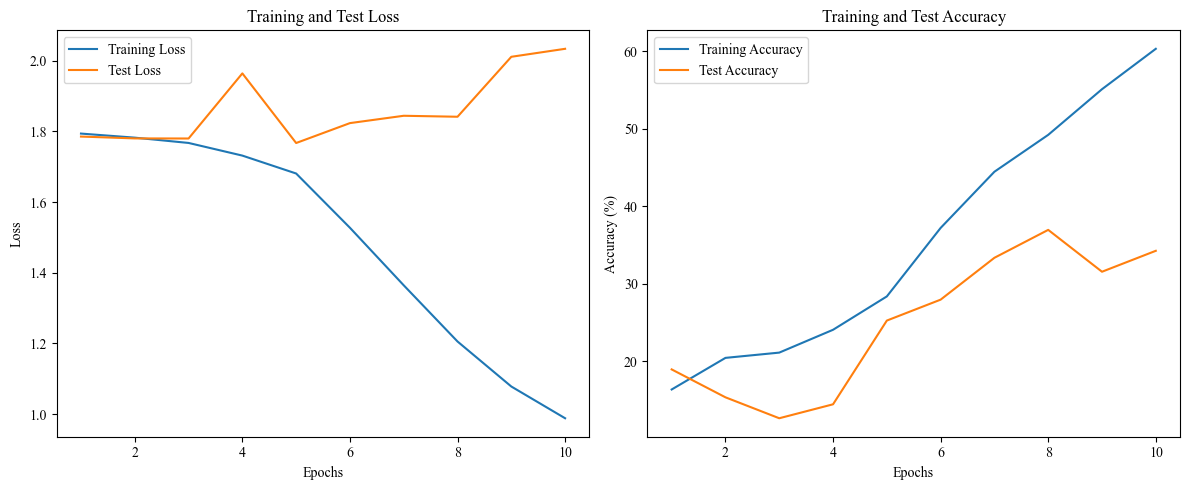

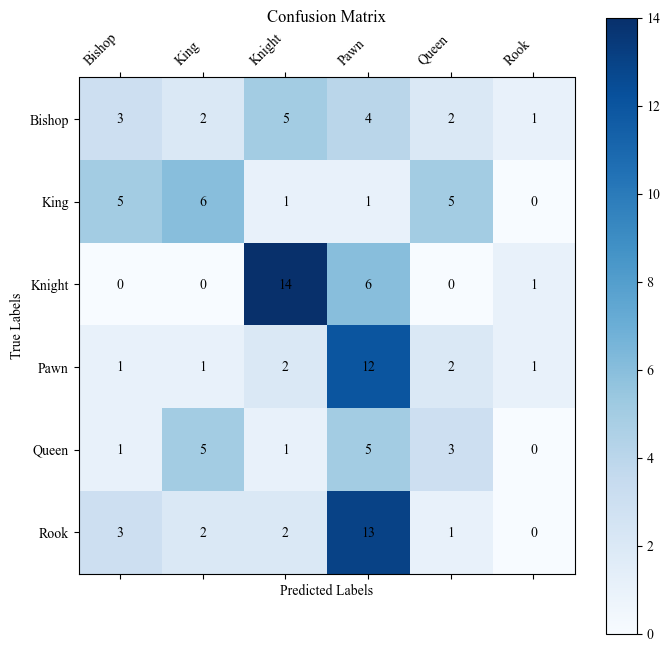

In [73]:
# Configuración inicial
model = ConvNet2(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

### **Clasificador Básico - Con 6 capas convolutivas y Dropout**

Epoch 1, Training Loss: 1.7900689712592535, Training Accuracy: 18.367346938775512%
Epoch 1, Test Loss: 1.7862875631877355, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7851728073188238, Training Accuracy: 15.873015873015873%
Epoch 2, Test Loss: 1.783611467906407, Test Accuracy: 18.91891891891892%
Epoch 3, Training Loss: 1.7851256387574332, Training Accuracy: 19.954648526077097%
Epoch 3, Test Loss: 1.7883674587522234, Test Accuracy: 17.117117117117118%
Epoch 4, Training Loss: 1.7862122995512826, Training Accuracy: 17.687074829931973%
Epoch 4, Test Loss: 1.784716282572065, Test Accuracy: 18.91891891891892%
Epoch 5, Training Loss: 1.7829812126500266, Training Accuracy: 19.047619047619047%
Epoch 5, Test Loss: 1.7856841768537248, Test Accuracy: 18.91891891891892%
Epoch 6, Training Loss: 1.7682594018323081, Training Accuracy: 19.047619047619047%
Epoch 6, Test Loss: 1.7589219297681535, Test Accuracy: 21.62162162162162%
Epoch 7, Training Loss: 1.7395723121506828, Training Accur

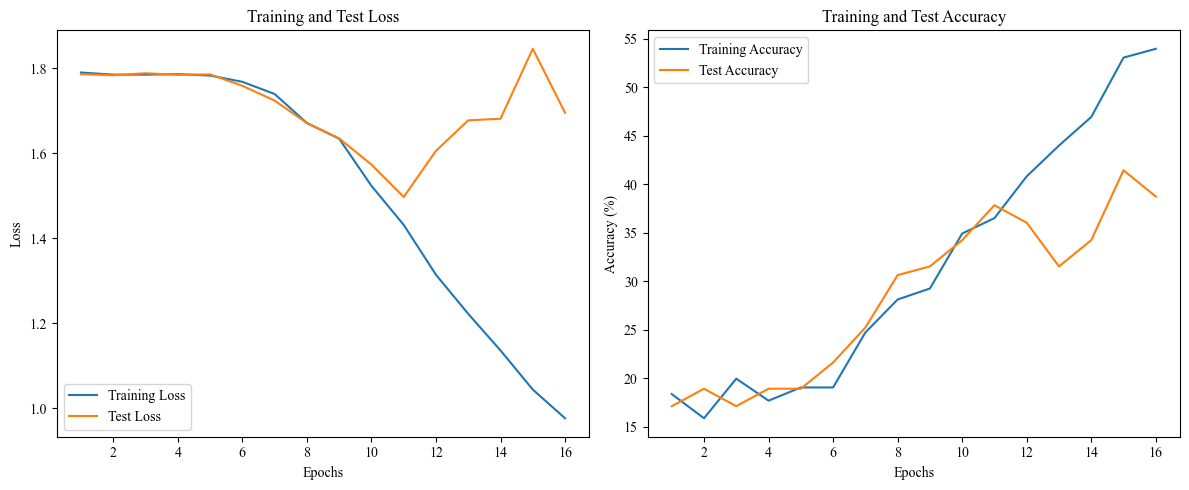

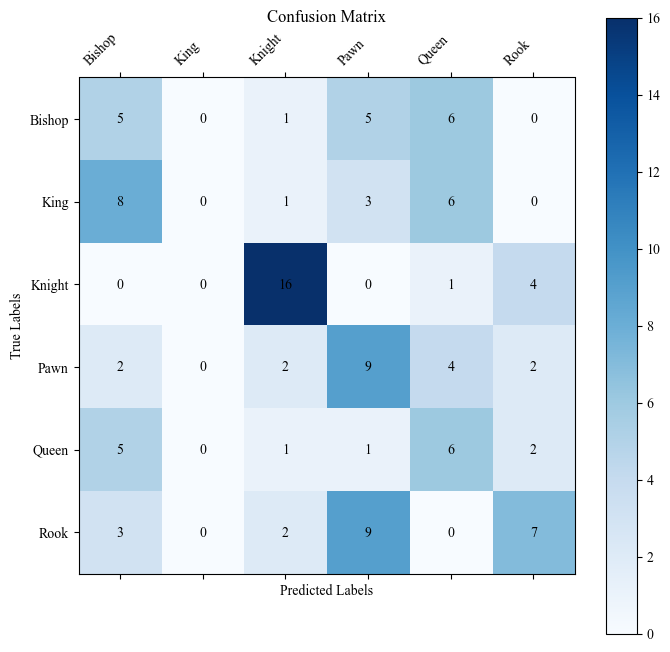

In [74]:
# Configuración inicial
model = ConvNet3(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

### **Preprocesamiento de Imágenes utilizando OpenCV**

#### **1. Detección de Bordes y Refinamiento de Imágenes**

In [89]:
def detect_edges_and_refine(image_path, save_processed_image=False, output_dir=None, fraction=1/2, grosor=1): 
    
    # Normalizar las barras en la ruta
    normalized_path = image_path.replace("\\", "/")

    # Verificar si la imagen existe
    if not os.path.exists(normalized_path):
        print(f"Error: La imagen {normalized_path} no existe.")
        return None

    # Intentar cargar la imagen
    image = cv2.imread(normalized_path)
    if image is None:
        print(f"Error: No se pudo cargar la imagen en {normalized_path}.\nPosiblemente esté dañada o el formato no es compatible.")
        return None

    # Redimensionar y preprocesar la imagen
    image_resized = cv2.resize(image, (256, 256))
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detección de bordes
    edges = cv2.Canny(blurred, threshold1=50, threshold2=200)

    # Engrosar bordes
    kernel = np.ones((3, 3), np.uint8)
    thick_edges = cv2.dilate(edges, kernel, iterations=2)

    # Encontrar contornos
    contours, _ = cv2.findContours(thick_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(image_resized)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), grosor)

    # Extraer una fracción de la imagen
    height, _ = contour_image.shape[:2]
    if not (0 < fraction <= 1):
        raise ValueError("fraction debe estar en el rango (0, 1].")
    upper_fraction = contour_image[:int(height * fraction), :]

    # Guardar la imagen procesada si se especifica
    if save_processed_image and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        processed_image_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(processed_image_path, upper_fraction)
    
    return upper_fraction

Este código implementa una función que detecta bordes en imágenes, refina los contornos y opcionalmente guarda una porción de la imagen procesada. Primero, valida que la imagen exista y pueda cargarse correctamente. Luego, realiza un preprocesamiento que incluye redimensionar la imagen a 256x256 píxeles, convertirla a escala de grises y suavizarla con un desenfoque gaussiano. A continuación, utiliza el detector de bordes Canny para identificar transiciones intensas, engrosando estos bordes mediante una dilatación. Posteriormente, detecta los contornos de las áreas resaltadas y los dibuja sobre una imagen en blanco. Finalmente, extrae una fracción específica de la imagen procesada (por defecto, la mitad superior) y, si se especifica, guarda esta imagen en un directorio de salida.

#### **2. Procesamiento del Conjunto de Datos**

In [90]:

def process_dataset(input_dir, output_dir, fraction = 1/2, grosor=1):
    
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_dir, class_name)
            os.makedirs(output_class_path, exist_ok=True)

            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    processed_image = detect_edges_and_refine(
                        image_path, save_processed_image=True, output_dir=output_class_path, fraction=fraction, grosor=grosor
                    )
                except Exception as e:
                    print(f"Error procesando {image_name}: {e}")

Este código define una función para procesar automáticamente un conjunto completo de datos de imágenes, aplicando la detección y refinamiento de bordes a cada archivo. Primero, crea un directorio de salida junto con subdirectorios que replican la estructura de clases del directorio de entrada. Luego, itera sobre cada clase (subcarpeta) y procesa todas las imágenes dentro de ella utilizando la función `detect_edges_and_refine`. Durante este procesamiento, maneja posibles errores individualmente para que no se interrumpa el análisis de todo el conjunto de datos. Las imágenes procesadas se guardan en el directorio de salida, manteniendo la organización de las carpetas del conjunto original.

#### **3. Procesamiento del Conjunto de Datos con Diferentes Configuraciones**

In [91]:
input_dataset_dir = os.path.join('datos_ajedrez', 'Chessman-image-dataset', 'Chess')

output_processed_dir = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed1')
process_dataset(input_dataset_dir, output_processed_dir, 1/2, 1)

output_processed_dir = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed2')
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 2)

output_processed_dir = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed3')
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 6)

output_processed_dir = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed4')
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 10)

Error: No se pudo cargar la imagen en datos_ajedrez/Chessman-image-dataset/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error procesando 00000139.fcgi: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

Error procesando 00000021.fcgi: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

Error procesando 00000170.php: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'

Error: No se pudo cargar la imagen en datos_ajedrez/Chessman-image-dataset/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el 

#### **4. Arquitectura de la Red Neuronal Convolutiva**
##### **ConvNet4**

In [92]:
class ConvNet4(nn.Module):
    def __init__(self, classes):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        # print(x.shape)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x) 
        return x

La red **ConvNet4** está diseñada con cuatro capas convolutivas seguidas de operaciones de pooling y dos capas totalmente conectadas al final. Esta arquitectura permite extraer características espaciales de las imágenes y realizar la clasificación en función de esas características.

##### **ConvNet5**

In [93]:

class ConvNet5(nn.Module):
    def __init__(self, classes):
        super(ConvNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        # print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

La red **ConvNet5** es una arquitectura más profunda y compleja, diseñada con seis capas convolutivas y operaciones de pooling, seguida de dos capas totalmente conectadas. Esta red puede capturar características más detalladas y complejas de las imágenes, lo que la hace ideal para tareas de clasificación en conjuntos de datos con alta variabilidad. También incorpora dropout para prevenir el sobreajuste.

#### **5. Transformaciones Avanzadas**

In [94]:
# Conjunto de Entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.4, hue=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Conjunto de Prueba
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### **Chess-processed1**

In [95]:
# Ruta de las imágenes
data_path = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed1')

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

Epoch 1, Training Loss: 1.7952836198466164, Training Accuracy: 18.820861678004537%
Epoch 1, Test Loss: 1.7909975562776839, Test Accuracy: 14.414414414414415%
Epoch 2, Training Loss: 1.783062960420336, Training Accuracy: 19.501133786848072%
Epoch 2, Test Loss: 1.8199126039232527, Test Accuracy: 14.414414414414415%
Epoch 3, Training Loss: 1.7791842903409685, Training Accuracy: 19.954648526077097%
Epoch 3, Test Loss: 1.7957116195133753, Test Accuracy: 12.612612612612613%
Epoch 4, Training Loss: 1.7816941099507468, Training Accuracy: 18.594104308390023%
Epoch 4, Test Loss: 1.8020144360406058, Test Accuracy: 12.612612612612613%
Epoch 5, Training Loss: 1.7776779873030526, Training Accuracy: 19.27437641723356%
Epoch 5, Test Loss: 1.8119751725878035, Test Accuracy: 12.612612612612613%
Epoch 6, Training Loss: 1.7771263676030296, Training Accuracy: 18.594104308390023%
Epoch 6, Test Loss: 1.8064217056546892, Test Accuracy: 12.612612612612613%
Parada temprana activada. No hay mejora en la pérdida 

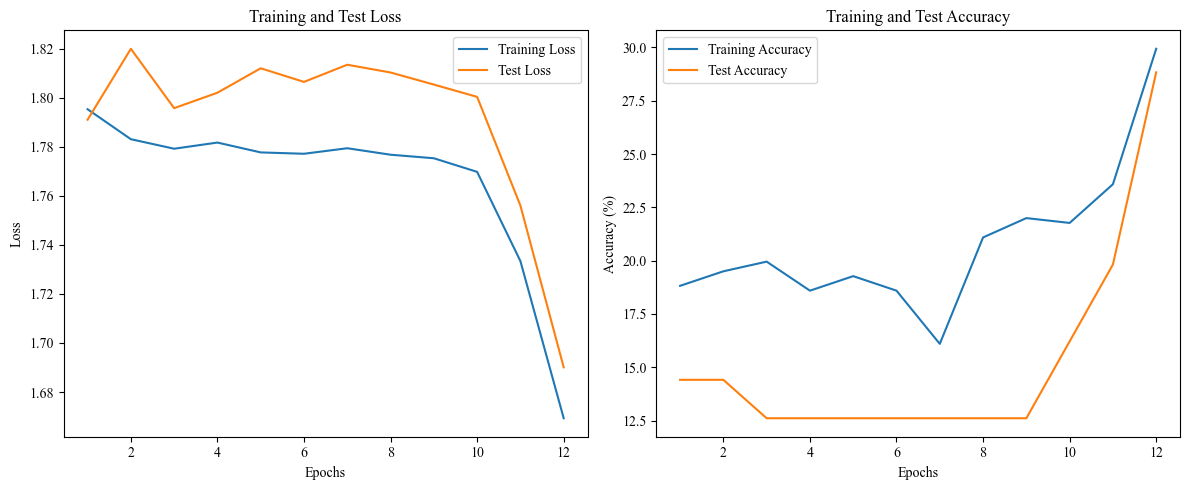

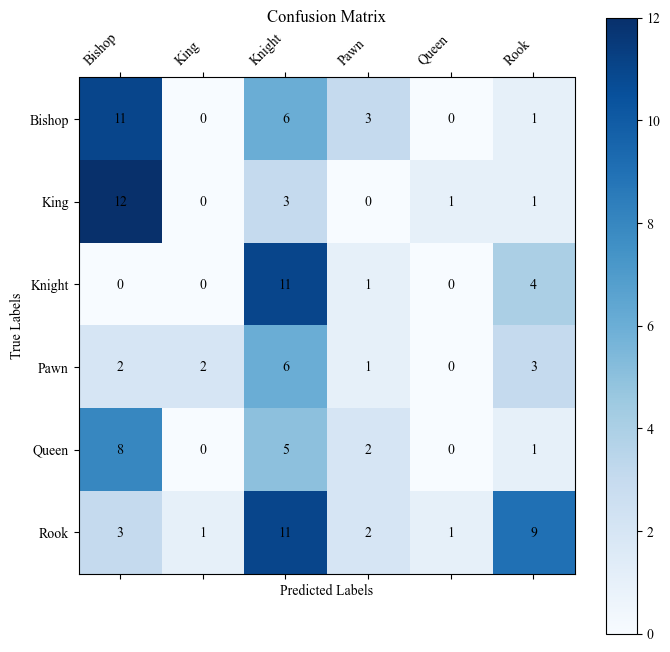

In [96]:
# Configuración inicial
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

### **Chess-processed2**

In [97]:
# Ruta de las imágenes
data_path = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed2')

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch 1, Training Loss: 1.8027501915182387, Training Accuracy: 17.913832199546484%
Epoch 1, Test Loss: 1.7975973061152868, Test Accuracy: 16.216216216216218%
Epoch 2, Training Loss: 1.789747178554535, Training Accuracy: 19.954648526077097%
Epoch 2, Test Loss: 1.7964453526905604, Test Accuracy: 16.216216216216218%
Epoch 3, Training Loss: 1.783616874899183, Training Accuracy: 19.501133786848072%
Epoch 3, Test Loss: 1.7876942328044347, Test Accuracy: 16.216216216216218%
Epoch 4, Training Loss: 1.785243775163378, Training Accuracy: 19.954648526077097%
Epoch 4, Test Loss: 1.788586003439767, Test Accuracy: 16.216216216216218%
Epoch 5, Training Loss: 1.7784428000450134, Training Accuracy: 19.954648526077097%
Epoch 5, Test Loss: 1.7815112727028983, Test Accuracy: 16.216216216216218%
Epoch 6, Training Loss: 1.760863529784339, Training Accuracy: 22.90249433106576%
Epoch 6, Test Loss: 1.7352914810180664, Test Accuracy: 18.91891891891892%
Epoch 7, Training Loss: 1.7007295659610204, Training Accura

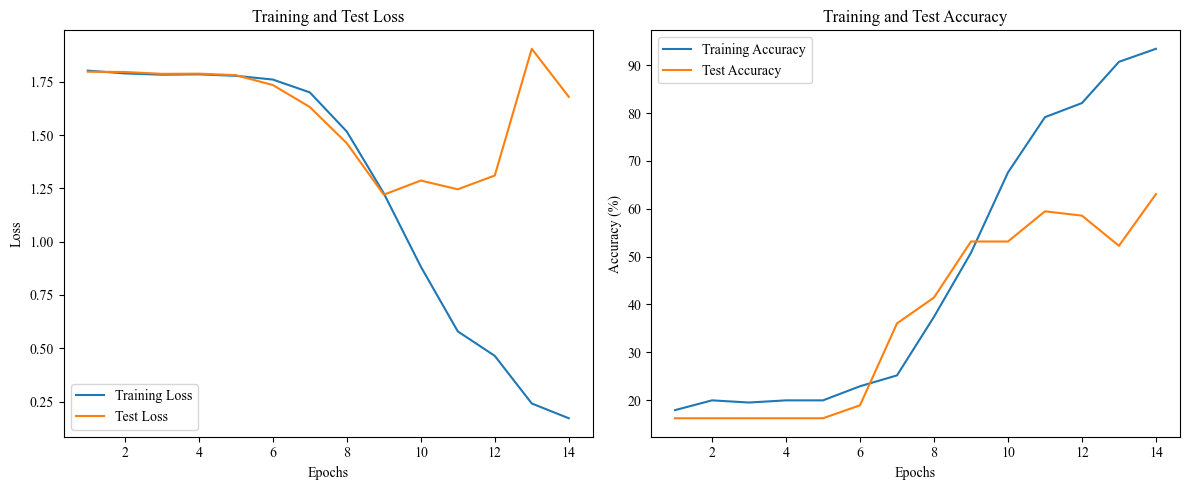

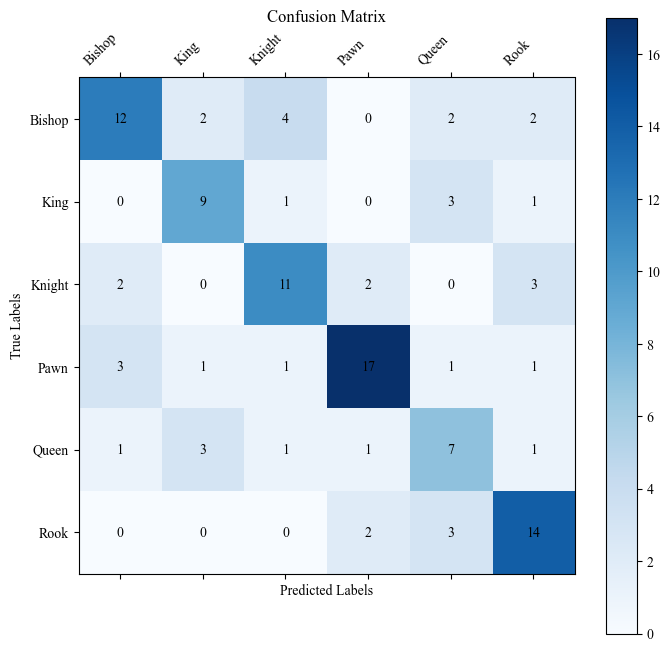

In [98]:
# Configuración inicial
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

### **Chess-processed3**

In [99]:
# Ruta de las imágenes
data_path = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed3')

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 1, Training Loss: 1.7940998332841056, Training Accuracy: 17.687074829931973%
Epoch 1, Test Loss: 1.7870843410491943, Test Accuracy: 18.01801801801802%
Epoch 2, Training Loss: 1.7745187027113778, Training Accuracy: 21.768707482993197%
Epoch 2, Test Loss: 1.719467282295227, Test Accuracy: 24.324324324324323%
Epoch 3, Training Loss: 1.6992911440985543, Training Accuracy: 27.664399092970523%
Epoch 3, Test Loss: 1.6509470641613007, Test Accuracy: 21.62162162162162%
Epoch 4, Training Loss: 1.6105128271239144, Training Accuracy: 27.664399092970523%
Epoch 4, Test Loss: 1.6539435386657715, Test Accuracy: 29.72972972972973%
Epoch 5, Training Loss: 1.5035187261445182, Training Accuracy: 35.147392290249435%
Epoch 5, Test Loss: 1.4842005670070648, Test Accuracy: 35.13513513513514%
Epoch 6, Training Loss: 1.2723075662340437, Training Accuracy: 45.57823129251701%
Epoch 6, Test Loss: 1.379985123872757, Test Accuracy: 42.34234234234234%
Epoch 7, Training Loss: 1.0839466878346034, Training Accurac

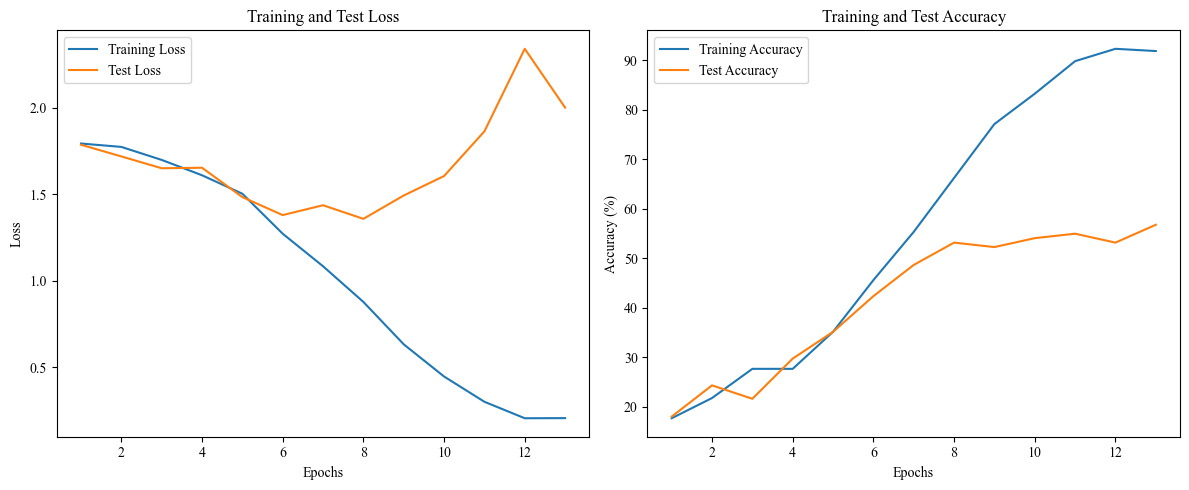

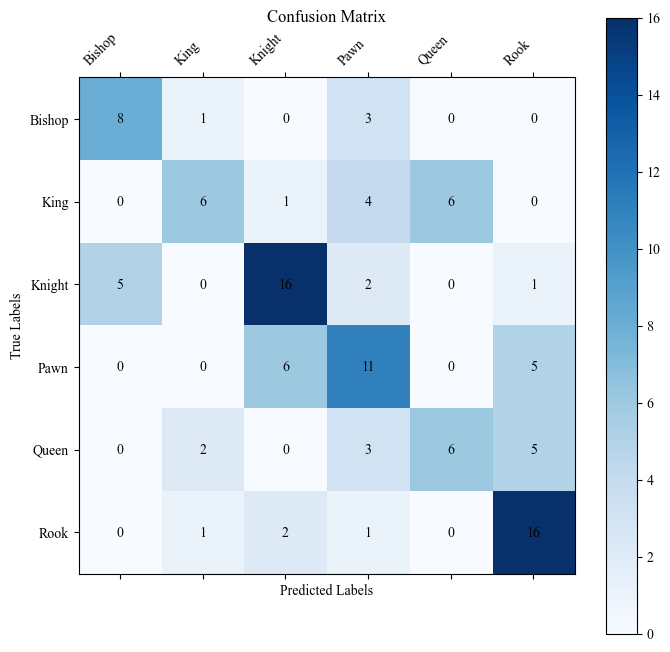

In [100]:
# Configuración inicial
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Epoch 1, Training Loss: 1.7925470897129603, Training Accuracy: 17.233560090702948%
Epoch 1, Test Loss: 1.7847647368907928, Test Accuracy: 18.01801801801802%
Epoch 2, Training Loss: 1.784069572176252, Training Accuracy: 16.55328798185941%
Epoch 2, Test Loss: 1.779892235994339, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.7698620813233512, Training Accuracy: 17.006802721088434%
Epoch 3, Test Loss: 1.7126103639602661, Test Accuracy: 21.62162162162162%
Epoch 4, Training Loss: 1.7164402859551566, Training Accuracy: 23.80952380952381%
Epoch 4, Test Loss: 1.661096841096878, Test Accuracy: 27.027027027027028%
Epoch 5, Training Loss: 1.635536083153316, Training Accuracy: 25.62358276643991%
Epoch 5, Test Loss: 1.6427324712276459, Test Accuracy: 27.027027027027028%
Epoch 6, Training Loss: 1.5196830119405473, Training Accuracy: 30.839002267573697%
Epoch 6, Test Loss: 1.5404347777366638, Test Accuracy: 33.333333333333336%
Epoch 7, Training Loss: 1.4553539752960205, Training Accuracy:

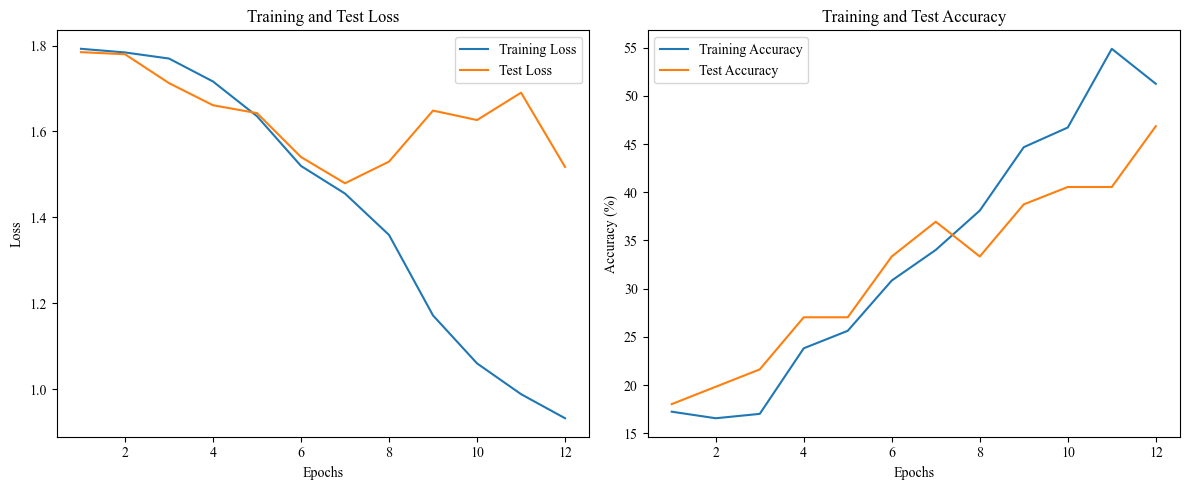

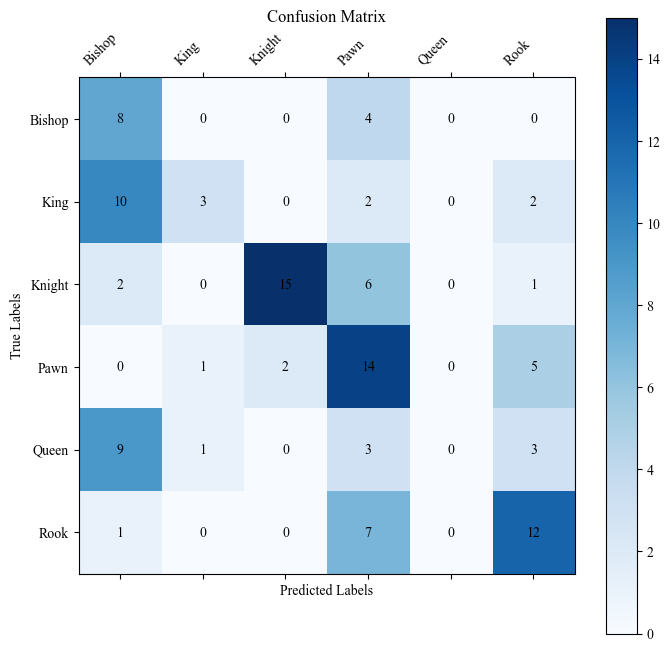

In [101]:
# Configuración inicial
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

### **Chess-processed4**

In [102]:
# Ruta de las imágenes
data_path = os.path.join('datos_ajedrez', 'Chessman-image-dataset-processed', 'Chess-processed4')

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 1, Training Loss: 1.7820168137550354, Training Accuracy: 21.08843537414966%
Epoch 1, Test Loss: 1.7795227468013763, Test Accuracy: 18.01801801801802%
Epoch 2, Training Loss: 1.7375378268105643, Training Accuracy: 24.71655328798186%
Epoch 2, Test Loss: 1.6523244976997375, Test Accuracy: 18.91891891891892%
Epoch 3, Training Loss: 1.6147166916302271, Training Accuracy: 34.467120181405896%
Epoch 3, Test Loss: 1.4980568587779999, Test Accuracy: 42.34234234234234%
Epoch 4, Training Loss: 1.3697747332709176, Training Accuracy: 46.25850340136054%
Epoch 4, Test Loss: 1.3860501646995544, Test Accuracy: 41.44144144144144%
Epoch 5, Training Loss: 1.1906246926103319, Training Accuracy: 53.51473922902494%
Epoch 5, Test Loss: 1.207864671945572, Test Accuracy: 54.95495495495496%
Epoch 6, Training Loss: 0.9509404301643372, Training Accuracy: 62.358276643990926%
Epoch 6, Test Loss: 1.2076836079359055, Test Accuracy: 57.65765765765766%
Epoch 7, Training Loss: 0.6991984588759286, Training Accuracy: 

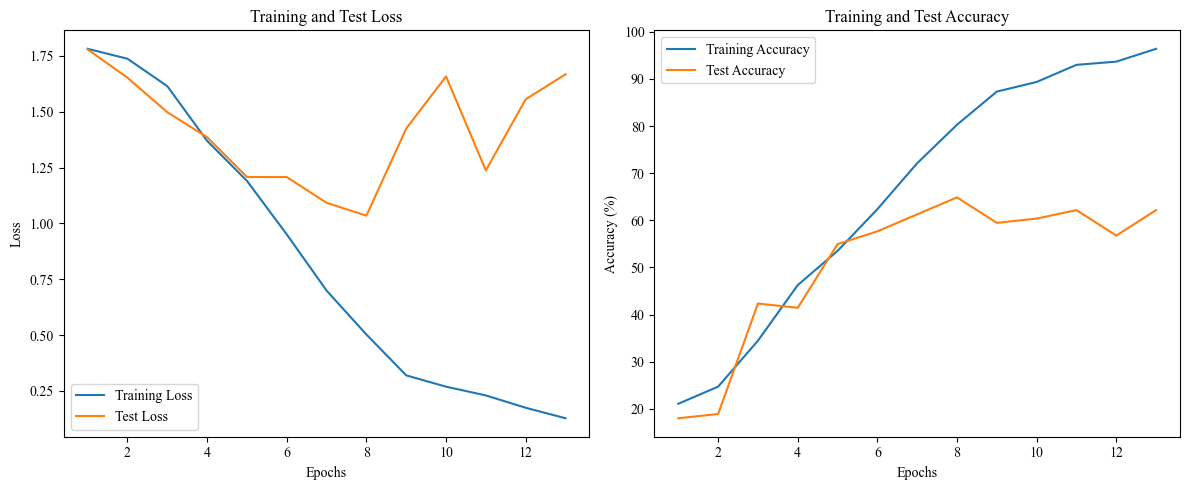

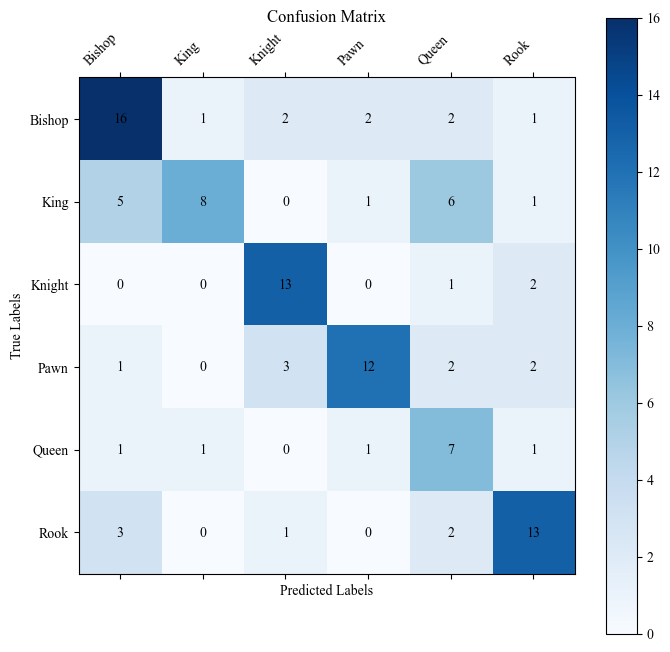

In [103]:
# Configuración inicial
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Epoch 1, Training Loss: 1.7905041149684362, Training Accuracy: 17.687074829931973%
Epoch 1, Test Loss: 1.8077604174613953, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7758091177259172, Training Accuracy: 19.954648526077097%
Epoch 2, Test Loss: 1.803135633468628, Test Accuracy: 14.414414414414415%
Epoch 3, Training Loss: 1.7666757447378976, Training Accuracy: 20.634920634920636%
Epoch 3, Test Loss: 1.7543913424015045, Test Accuracy: 21.62162162162162%
Epoch 4, Training Loss: 1.7328026975904192, Training Accuracy: 24.94331065759637%
Epoch 4, Test Loss: 1.7094182670116425, Test Accuracy: 19.81981981981982%
Epoch 5, Training Loss: 1.6823588694844926, Training Accuracy: 30.839002267573697%
Epoch 5, Test Loss: 1.6395609974861145, Test Accuracy: 19.81981981981982%
Epoch 6, Training Loss: 1.5716945784432548, Training Accuracy: 31.972789115646258%
Epoch 6, Test Loss: 1.5273075699806213, Test Accuracy: 27.027027027027028%
Epoch 7, Training Loss: 1.4308743136269706, Training Accu

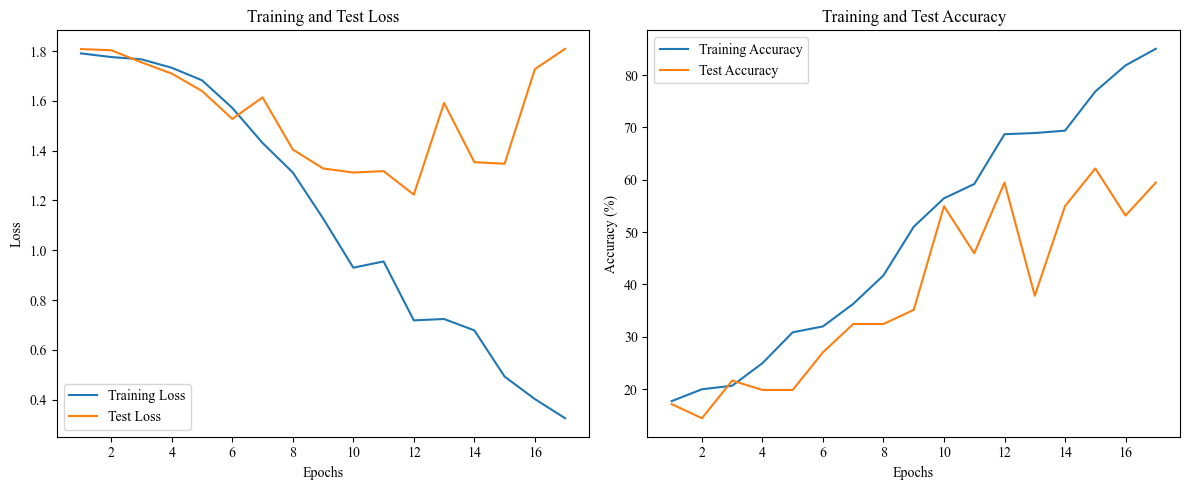

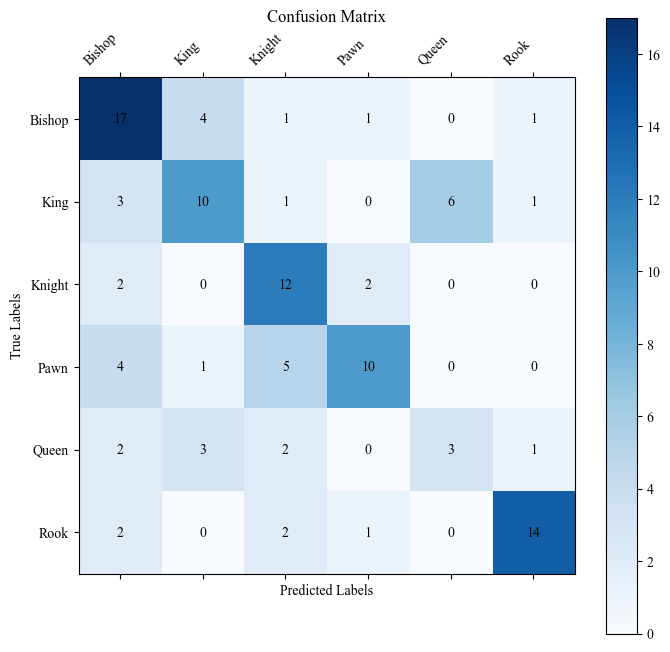

In [104]:
# Configuración inicial
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

### **ResNet18**

#### **1. Recorte de la Parte Superior en Imágenes**

In [127]:
def crop_top(img):
    width, height = img.size
    return img.crop((0, 0, width, int(height * 0.6)))

#### **2. Transformaciones y Carga de Datos**

In [128]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Lambda(crop_top),
    transforms.Resize((224, 224)), # Redimensionamos las imágenes a 224x224 píxeles
    transforms.ToTensor(), # Convertimos las imágenes en tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizamos los datos en el rango [-1, 1]
])

# Ruta de las imágenes
data_path = os.path.join('datos_ajedrez', 'Chessman-image-dataset', 'Chess')

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

#### **3. Entrenamiento del Modelo**

In [131]:
# Cargar un modelo preentrenado (ResNet18)
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_data.classes))  # Ajustar la salida al número de clases

# Definir optimizador y función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Entrenamiento
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    # Modo de entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Entrenamiento en el conjunto de entrenamiento
    for images, labels in train_loader:
        # Mover datos al mismo dispositivo que el modelo
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos

        # Calcular precisión en el conjunto de entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Acumular la pérdida
        running_loss += loss.item()

    # Guardar pérdida y precisión del conjunto de entrenamiento para la época actual
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {100 * correct / total}%")

    # Evaluación en el conjunto de prueba
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():  # No calcular gradientes durante la evaluación
        for images, labels in test_loader:
            # Mover datos al mismo dispositivo que el modelo
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculamos la pérdida en el conjunto de prueba

            # Calcular precisión en el conjunto de prueba
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Guardar etiquetas reales y predichas para la matriz
            all_labels.extend(labels.cpu().numpy())  # Mover a la CPU antes de convertir a numpy
            all_preds.extend(predicted.cpu().numpy())  # Mover a la CPU antes de convertir a numpy

            # Acumular la pérdida del conjunto de prueba
            test_loss += loss.item()

    # Guardar pérdida y precisión del conjunto de prueba para la época actual
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * correct / total}%")

Epoch 1, Training Loss: 1.0126341262034007, Training Accuracy: 63.038548752834465%
Epoch 1, Test Loss: 1.5105206370353699, Test Accuracy: 72.07207207207207%
Epoch 2, Training Loss: 0.4782426916062832, Training Accuracy: 82.08616780045351%
Epoch 2, Test Loss: 0.6202843423400607, Test Accuracy: 81.98198198198199%
Epoch 3, Training Loss: 0.2996365792517151, Training Accuracy: 91.15646258503402%
Epoch 3, Test Loss: 0.33828477774347576, Test Accuracy: 88.28828828828829%
Epoch 4, Training Loss: 0.2988847440906933, Training Accuracy: 91.83673469387755%
Epoch 4, Test Loss: 0.44093918587480274, Test Accuracy: 85.58558558558559%
Epoch 5, Training Loss: 0.12870255481850887, Training Accuracy: 96.14512471655328%
Epoch 5, Test Loss: 0.678337245115212, Test Accuracy: 80.18018018018019%
Epoch 6, Training Loss: 0.13879848790488072, Training Accuracy: 94.78458049886622%
Epoch 6, Test Loss: 0.549744746514729, Test Accuracy: 87.38738738738739%
Epoch 7, Training Loss: 0.15548264291802688, Training Accurac

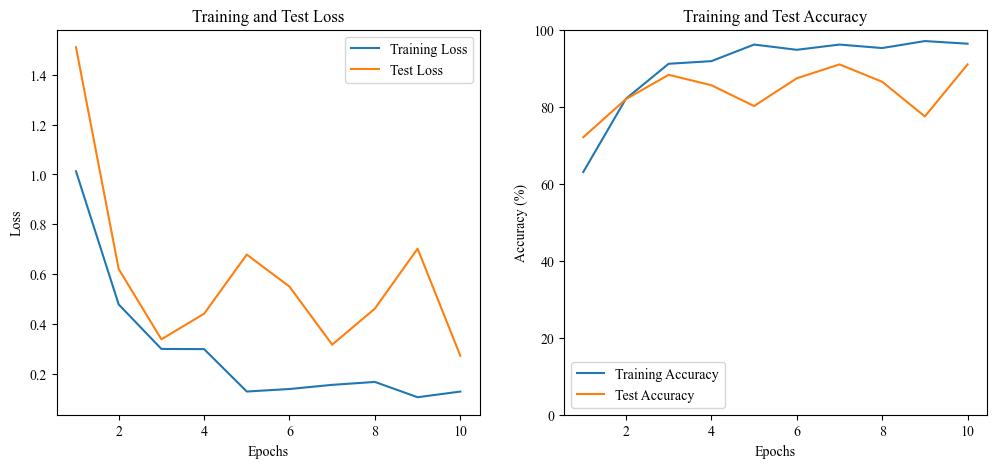

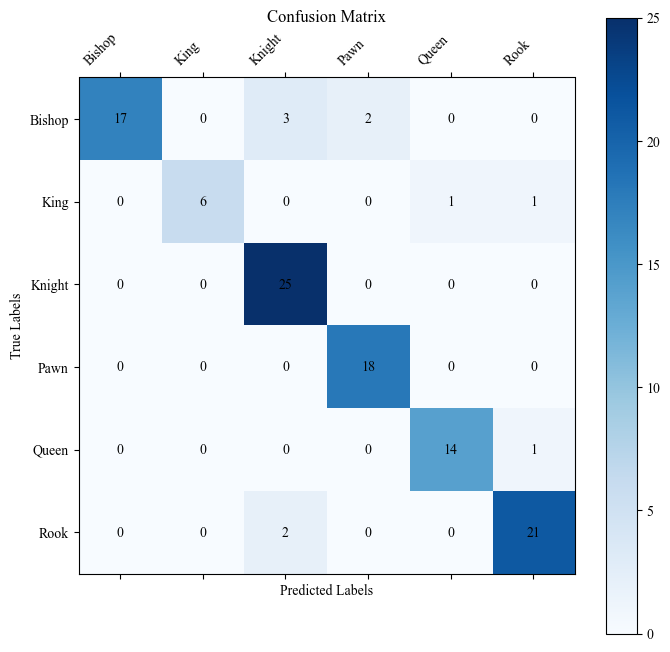

In [ ]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Gráfico de pérdidas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)  # Escala de 0 a 100
plt.title("Training and Test Accuracy")
plt.legend()

# Matriz de Confusión
num_classes = len(full_data.classes)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    confusion_matrix[true_label, pred_label] += 1

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(confusion_matrix, cmap='Blues')
plt.colorbar(cax)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(full_data.classes, rotation=45, ha="right")
ax.set_yticklabels(full_data.classes)

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()